## Linear Supervised Learning Series

# Part 5: One-versus-all multiclass classification

In practice many classification problems have more than two classes we wish to distinguish, e.g., face recognition, hand gesture recognition, general object detection, speech recognition, and more.


In the next two posts we discuss two popular generalizations of the two class framework discussed previously for multiclass classification - namely, *One-versus-All* and *multiclass logistic regression* (the latter of which is also referred to as *multiclass softmax classification* or *softmax regression*).  For a dataset consisting of $C$ classes both schemes learn $C$ two class linear classifiers - each of which distinguishes a single class from all others - fusing them together to create multi-class classifier.  These two popular approaches fuse the $C$ linear classifiers together in essentially the same manner, differing only in how the individual classifiers are trained: in the One-versus-All scheme each classifier is trained independently from the others, while with multiclass logistic regression all are tuned simultaneously.  Akin to say logistic regression versus support vector machines, both multiclass methods are commonly used and perform similarly in practice.

In [1]:
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
from mlrefined_libraries import superlearn_library as superlearn
import autograd.numpy as np
import pandas as pd
%matplotlib notebook

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

# 1.  One-versus-All multiclass classification 

Because it has only two sides, a single linear separator is fundamentally insufficient as a mechanism for differentiating between more than two classes of data. However we can use our understanding of two-class classification to overcome this shortcoming when dealing with $C>2$ classes by learning $C$ linear classifiers (one per class), each distinguishing one class from the rest of the data.  The trick of the matter is how we should combine these individual classifiers to create a reasonable multiclass decision boundary.  We will develop this scheme step-by-step by studying how such an idea should unfold on a toy dataset.  With due diligence and a little common sense we can intuitively derive universal ideas regarding multi-class classification that are the basis for most popular multiclass classification schemes, including One-versus-All (OvA) classification.

## 1.1 Multiclass data

A multiclass dataset $\left\{ \left(\mathbf{x}_{p,}\,y_{p}\right)\right\} _{p=1}^{P}$
consists of $C$ distinct classes of data.  As with the two-class case we can in theory use any $C$ distinct labels to distinguish between the classes, but for future derivations it is convenient use label values $y_{p}\in\left\{ 1,2,...,C\right\} $.  Tbe next Python cell loads in and plots the $C = 3$ class dataset we will use in our derivation of OvA.  Afterwards we will apply what we have developed to other datasets as well.

<IPython.core.display.Javascript object>


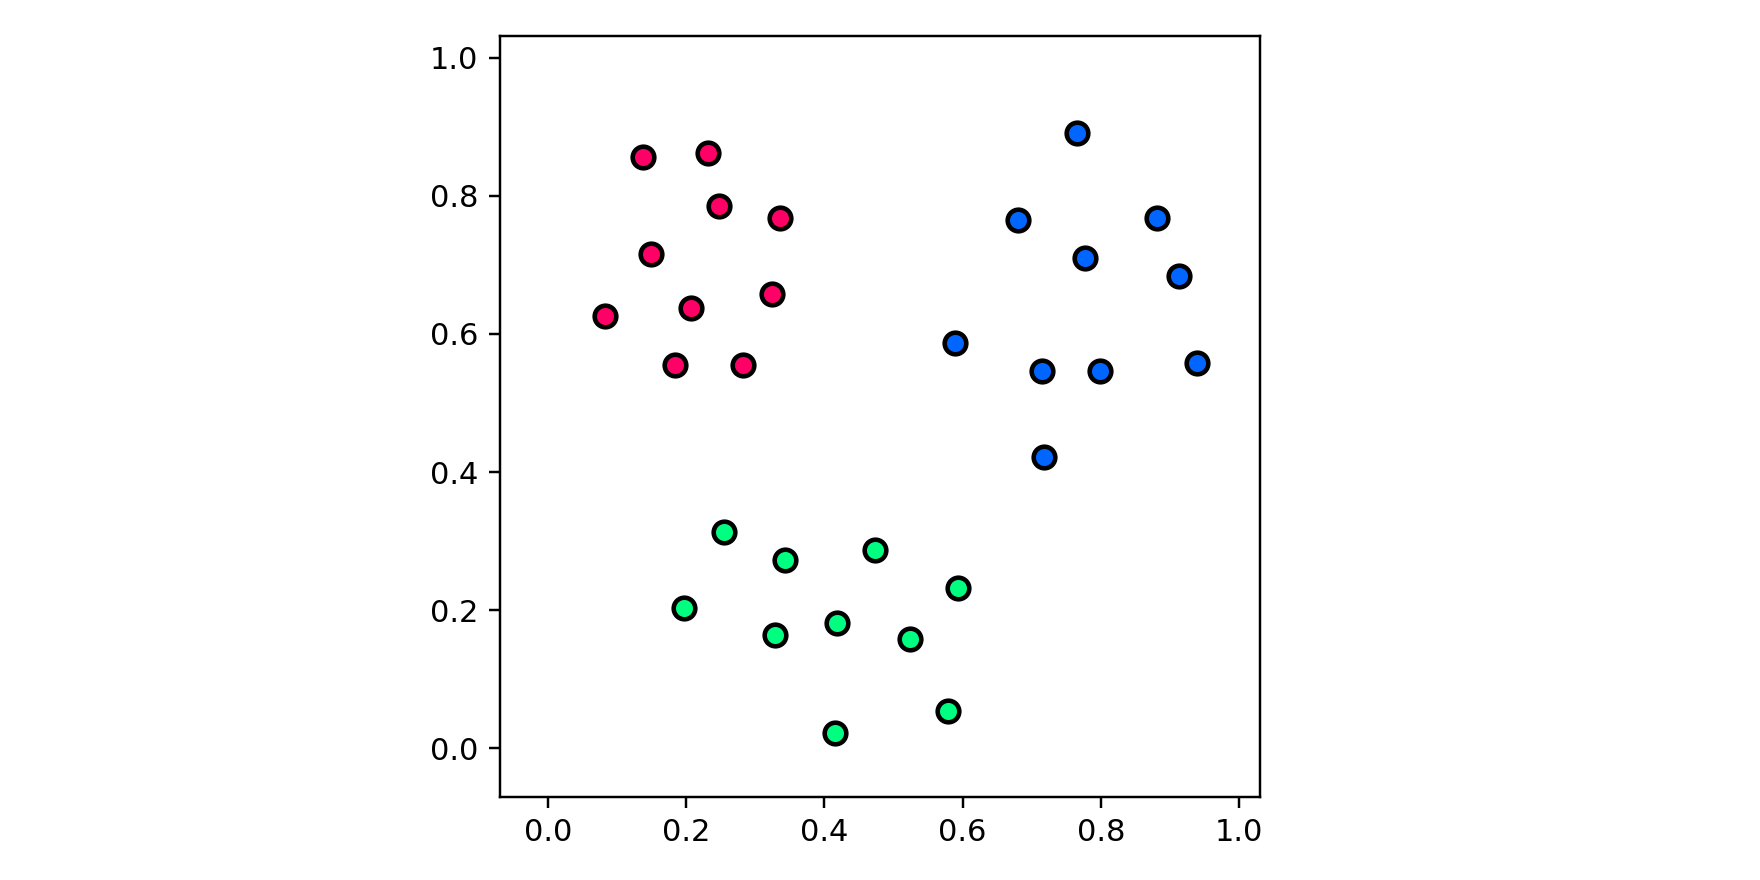

In [2]:
# load in dataset
data = np.loadtxt('../../mlrefined_datasets/superlearn_datasets/3class_data.csv',delimiter = ',')

# create an instance of the ova demo
demo1 = superlearn.ova_illustrator.Visualizer(data)

# visualize dataset
demo1.show_dataset()

##  1.2  Training  $C$ one-versus-all classifiers

The first step of OvA classification is simple - we reduce the new problem of multiclass classification into a sequence of smaller problems that we are already familiar with.  If we reflect for a moment on what we want, one way of phrasing the goal of multiclass classificaiton is that *we want to learn how to distinguish each class of our data from the other $C-1$ classes*.  From this perspective it certainly seems that a good first step towards accomplishing our goal would be to learn $C$ two-class classifiers on the entire dataset, with the $c^{th}$ classifier trained to distinguish the $c^{th}$ class from the remainder of the data.  With the $c^{th}$ two-class subproblem we simply assign temporary labels $\hat y_p$ to the entire dataset - giving $+1$ labels to the $c^{th}$ class and $-1$ labels to the remainder of the dataset i.e.,

\begin{equation}
\hat y_p = \begin{cases}   +1 \,\,\,\,\,\,\text{if} y_p = c \\ -1 \,\,\,\,\,\,\text{if} y_p \neq c    \end{cases}
\end{equation}

where again $y_p$ is the original label for the $p^{th}$ point, and run the two-class classification scheme of our choice.

Doing this for our $C = 3$ dataset we end up learning 3 linear classifiers - here we use logistic regression for each subproblem, solving each using Newton's method.  This is performed by activating the next Ptyhon cell.

In [3]:
# solve the 2-class subproblems
demo1.solve_2class_subproblems()

With our classifiers trained we can now illustrate our learned decision boundaries - each learned to distinguish a single class from the remainder of the data.  The next Python cell plots two rows of images - in the top row our original dataset is plotted three times with each instance showing just one of the three two-class classifiers learned.  The single class being distinguished is colored with its original color - with the corresponding learned decision boundary colored similarly - and all other data is colored gray.  In the bottom row the dataset is shown with along with all three learned decision boundaries.

<IPython.core.display.Javascript object>


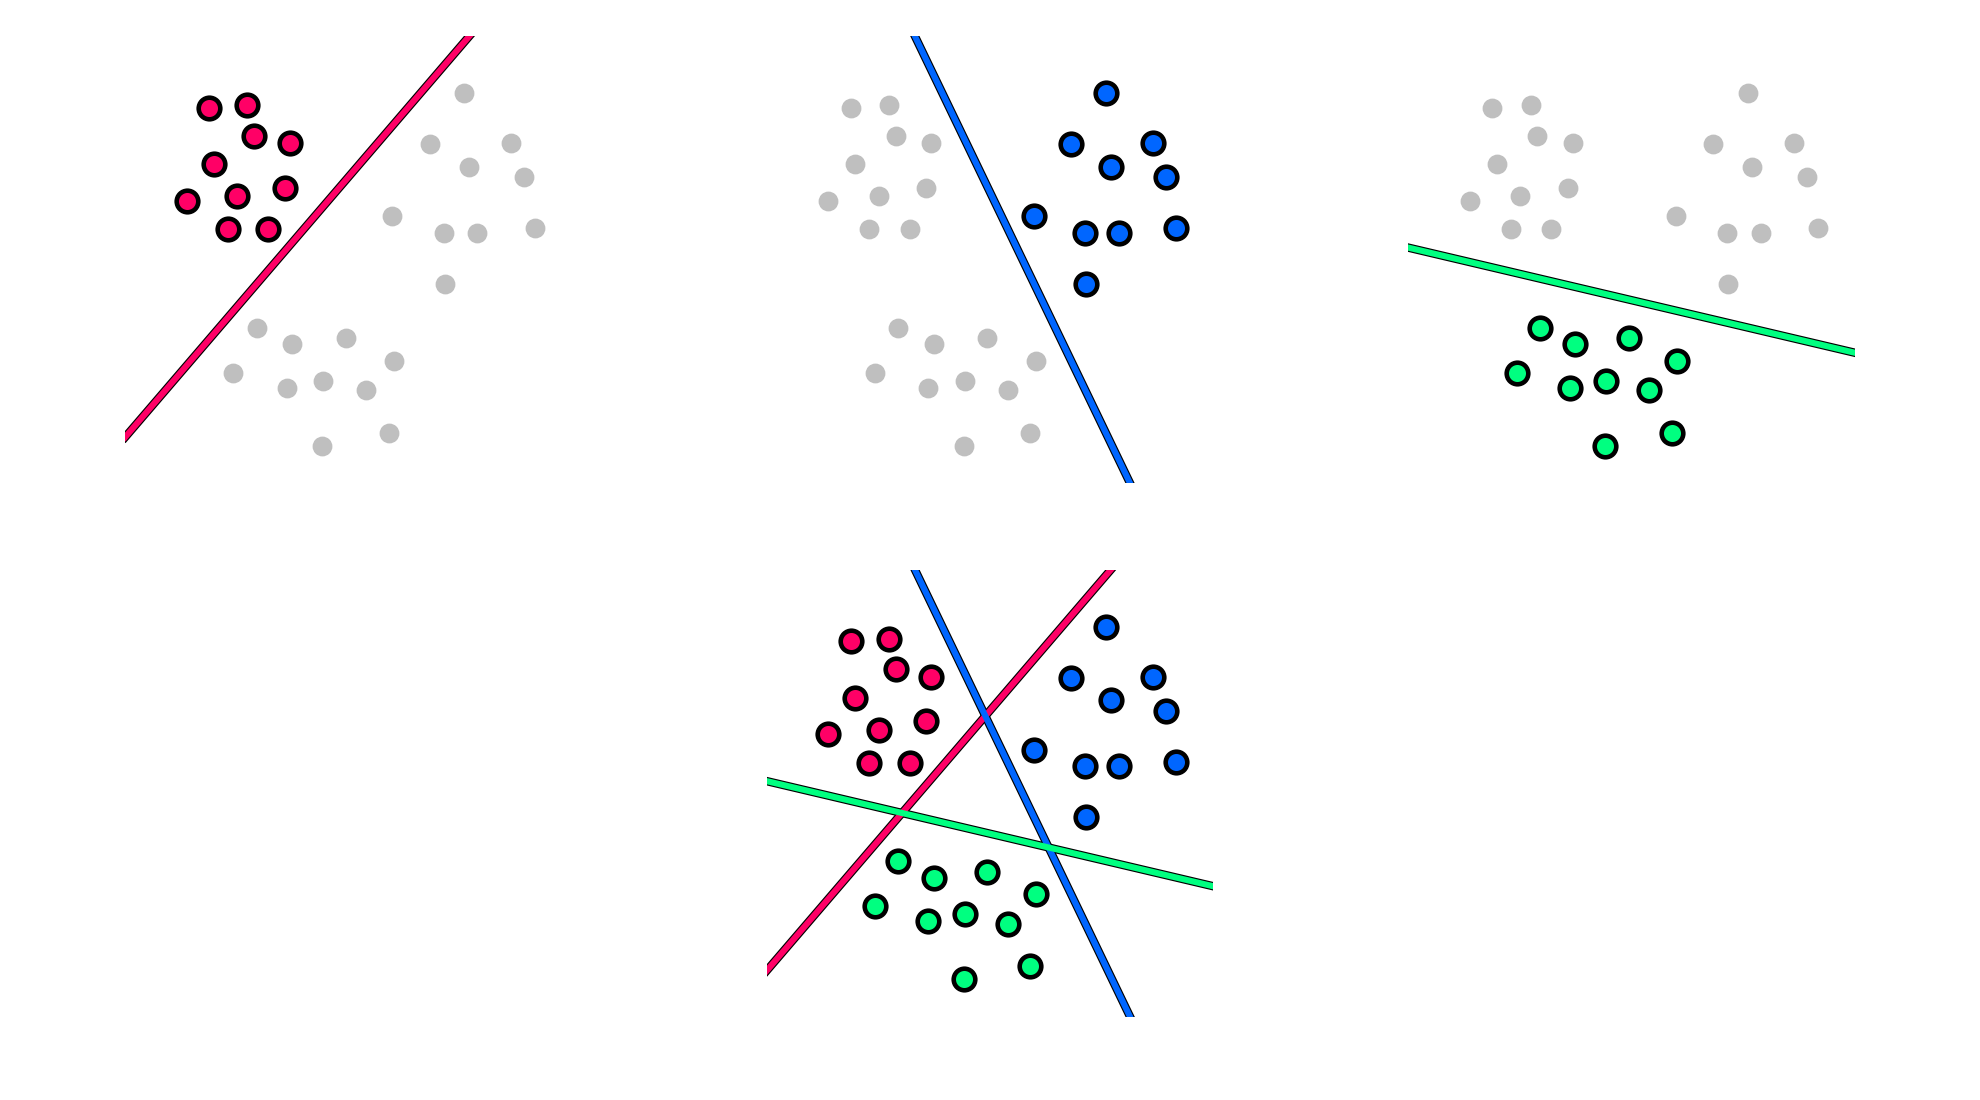

In [14]:
# illustrate dataset with each subproblem and learned decision boundary
demo1.plot_data_and_subproblem_separators()

Now we have learned $C$ two-class classifiers, learning the bias/slope weights  $\left(w_0^{(1)},\,\mathbf{w}_{\mathstrut}^{(1)} \right)\,\left(w_0^{(2)},\,\mathbf{w}_{\mathstrut}^{(2)}\right),,...,\left(w_0^{(C)},\,\mathbf{w}_{\mathstrut}^{(C)}\right)$ respectively - the $C$ associated linear decision boundaries the $c^{th}$ of which can be written as

\begin{equation}
w_0^{(c)} + \mathbf{x}_{\mathstrut}^T\mathbf{w}_{\mathstrut}^{(c)} = 0
\end{equation}

Note in the figure above how in each case that - because each subproblem is perfectly linearly separable and because of our choice of temporary labels - that the class to be distinguished from the rest lies on the *positive side* of its respective classifier, with the remainder of the points lying on the *negative side*.  This of course means that for the $c^{th}$ classifier we have for the $p^{th}$ point $\mathbf{x}_p$ that

\begin{equation}
w_0^{(c)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(c)} =  \begin{cases}   > 0 \,\,\,\,\,\,\text{if}\,\,\, y_p = c  \\ < 0 \,\,\,\,\,\, \text{if} \,\,\, y_p \neq c.    \end{cases}
\end{equation}

Another way of saying this that - when evaluated by each two-class classifier individually - the one learned to a point's true label always provides the largest evaluation i.e.,

\begin{equation}
w_0^{(c)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(c)} = \underset{j=1,...,C}{\text{max}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,j)}.
\end{equation}


So we know how to classify the points that we have, what about those we do not?  How do we classify arbitrary points in the space of our example?  Lets figure this out step-by-step.  

First, those points that lie solely on the positive side of the $c^{th}$ classifier only - like the points we already have - should clearly belong to the $c^{th}$ class.  Such a point $\mathbf{x}$ lies close to those we already have, also clearly satisfying the condition that $w_0^{(c)} + \mathbf{x}_{\mathstrut}^T\mathbf{w}_{\mathstrut}^{(c)} = \underset{j=1,...,C}{\text{max}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{\mathstrut}^T\mathbf{w}_{\mathstrut}^{(\,j)}$.  We color in the points representing these areas of the space of our dataset in via the Python cell below.  

Notice the regions left un-colored, that do not fall into this first category (of being on the positive side of a single classifier).  These include regions where points are on the positive side of more than one classifier - these are the three triangular white regions bordered by *two* decision boundaries.  For example points in the white region at the top - bordered by the red and blue decision boundaries - are on the positive side of both the red and blue classifiers.  The un-colored regions also include the one in the very middle of the plot - whose points are on the negative side of all three classifiers.

<IPython.core.display.Javascript object>


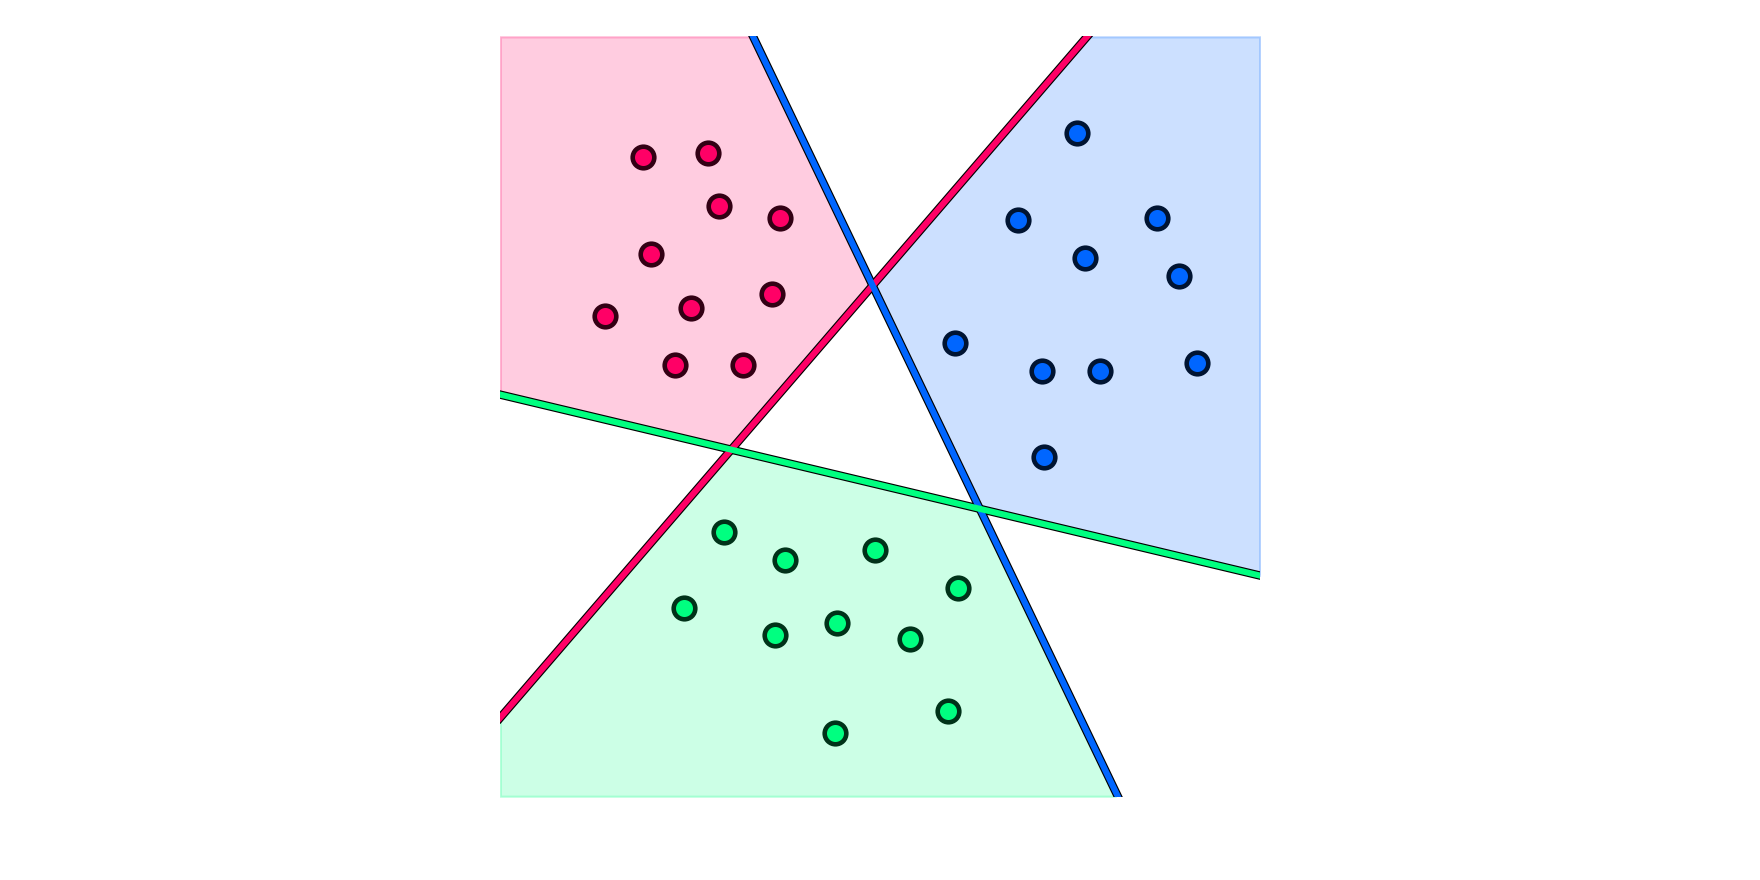

In [4]:
# color those points clearly belonging to each individual class - those lying near the points we already have on the positive side of only one classifier.
demo1.show_fusion(region = 1)

Let us first deterimine how to appropriately classify points in those un-colored regions where more than one classifier is positive, and for simplicity lets look at the top region that is on the positive side of both the red and blue classifiers (the other regions should behave similarly).

Lets look at a point in this region - as shown by the Python cell below.  Which class should it be assigned too?  Recall that when we discussed logistic regression that we think of a classifier as being 'more confident' of the class identity of a point the *farther* the point lies from the classifier's decision boundary.  This is a simple geometric / probablistic concept, the bigger a point's distance to the boundary the deeper into one region of a classifier's space it lies, and thus we can be much more confident in its class than a point arbitrarily close to the boundary. 



<IPython.core.display.Javascript object>


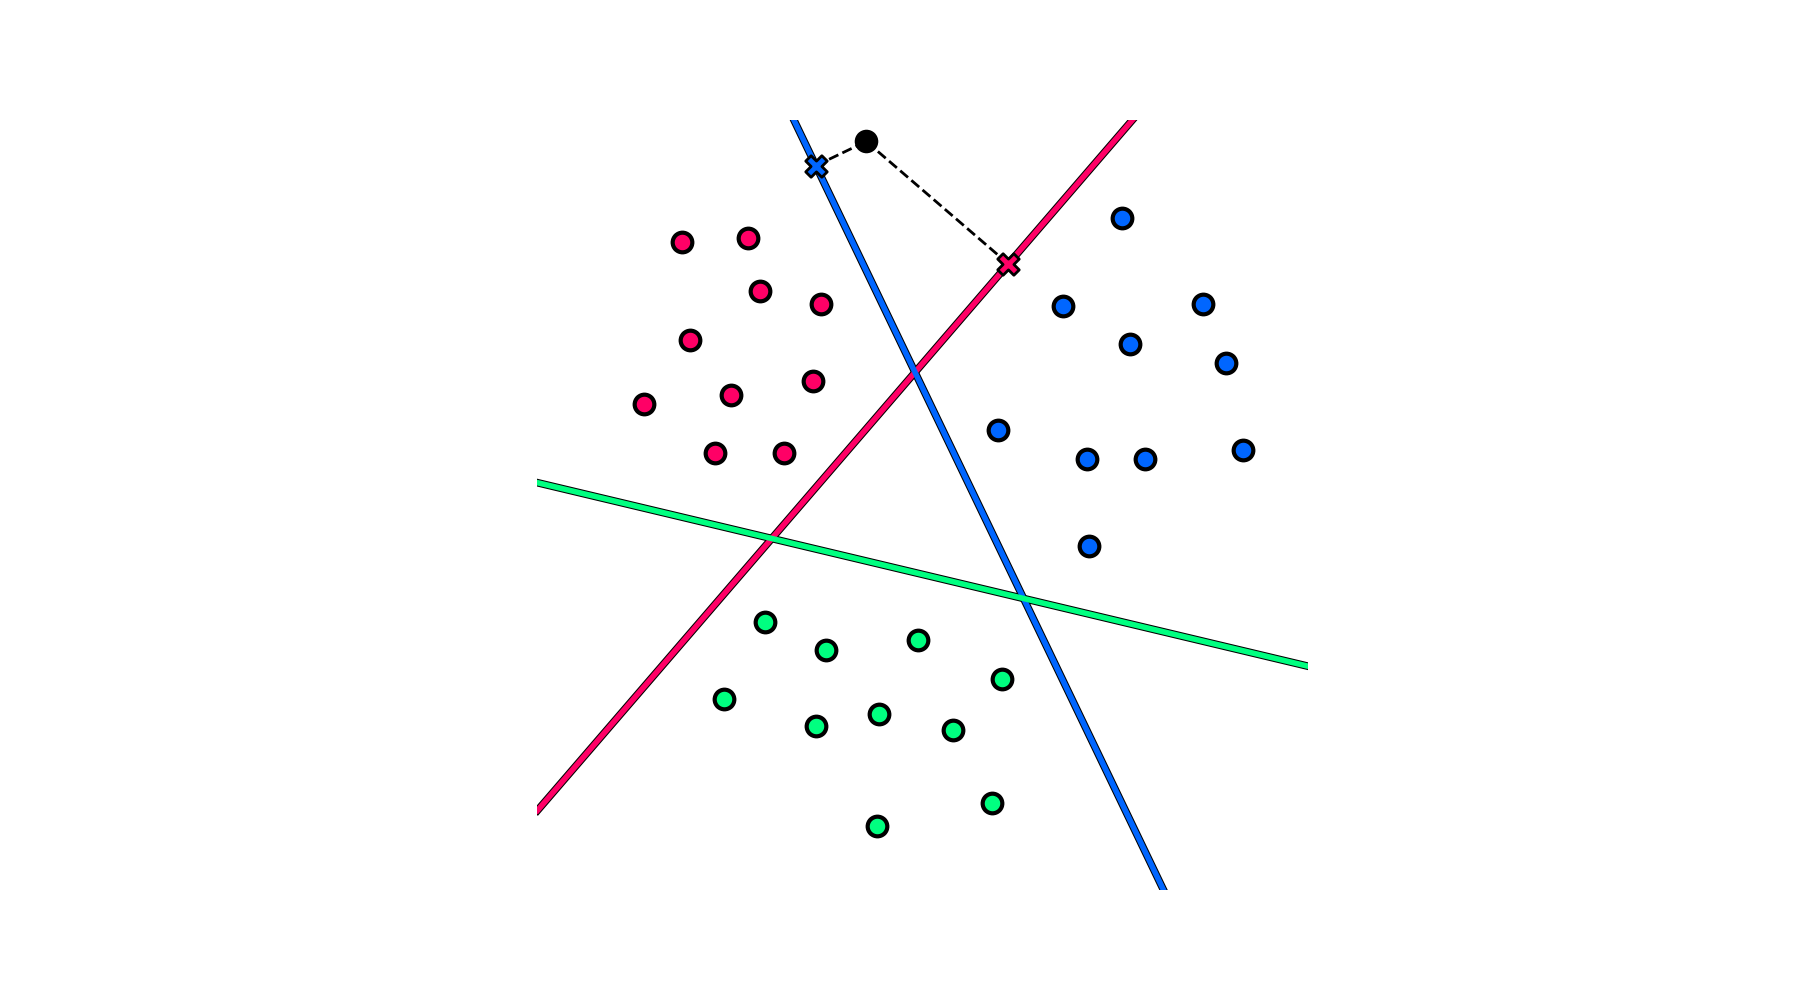

In [72]:
demo1.point_and_projection(point = [0.4,1])

In [23]:
demo1.W

[[-0.081538349563438833, -0.75758785300057374, 0.65273321118660799],
 [-0.71340783541647856, 0.90150766113477299, 0.43276314181698899],
 [0.48213173186876962, -0.23167233160713693, -0.97279387887039703]]

<IPython.core.display.Javascript object>


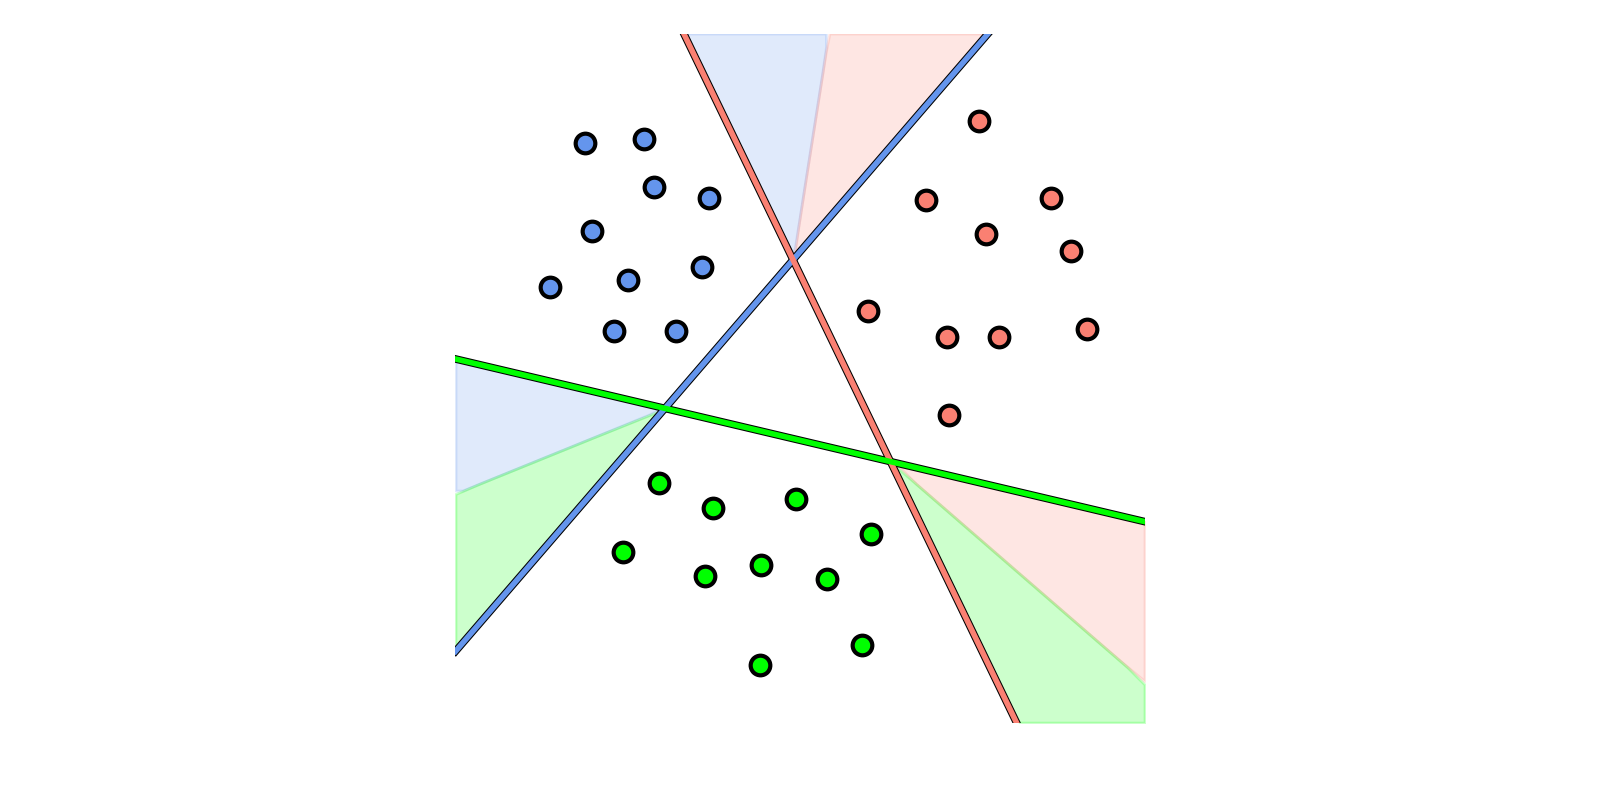

In [58]:
demo1.show_fusion(region = 2)

<IPython.core.display.Javascript object>


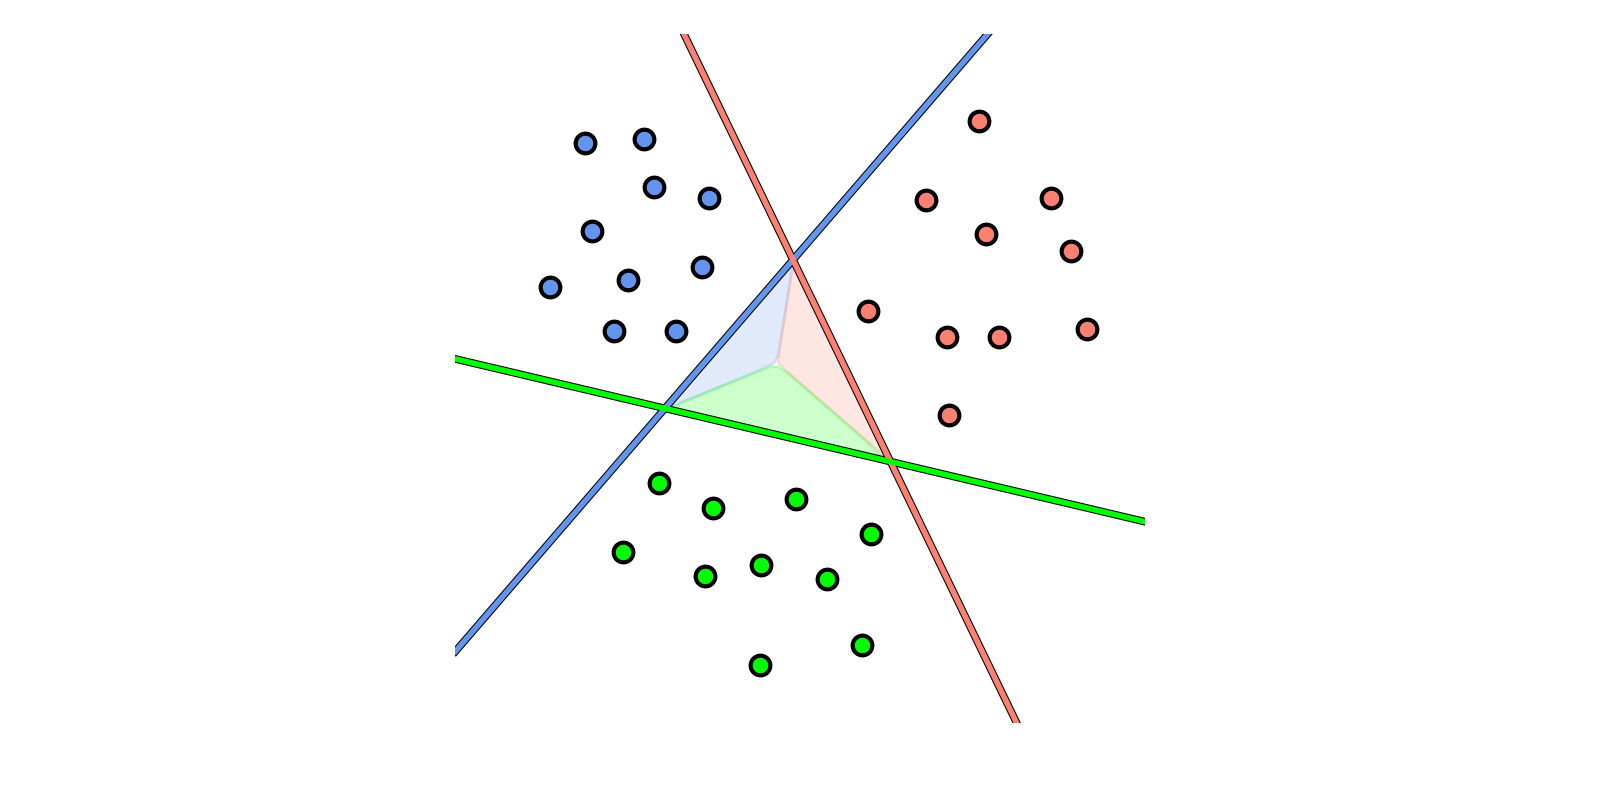

In [59]:
demo1.show_fusion(region = 3)

<IPython.core.display.Javascript object>


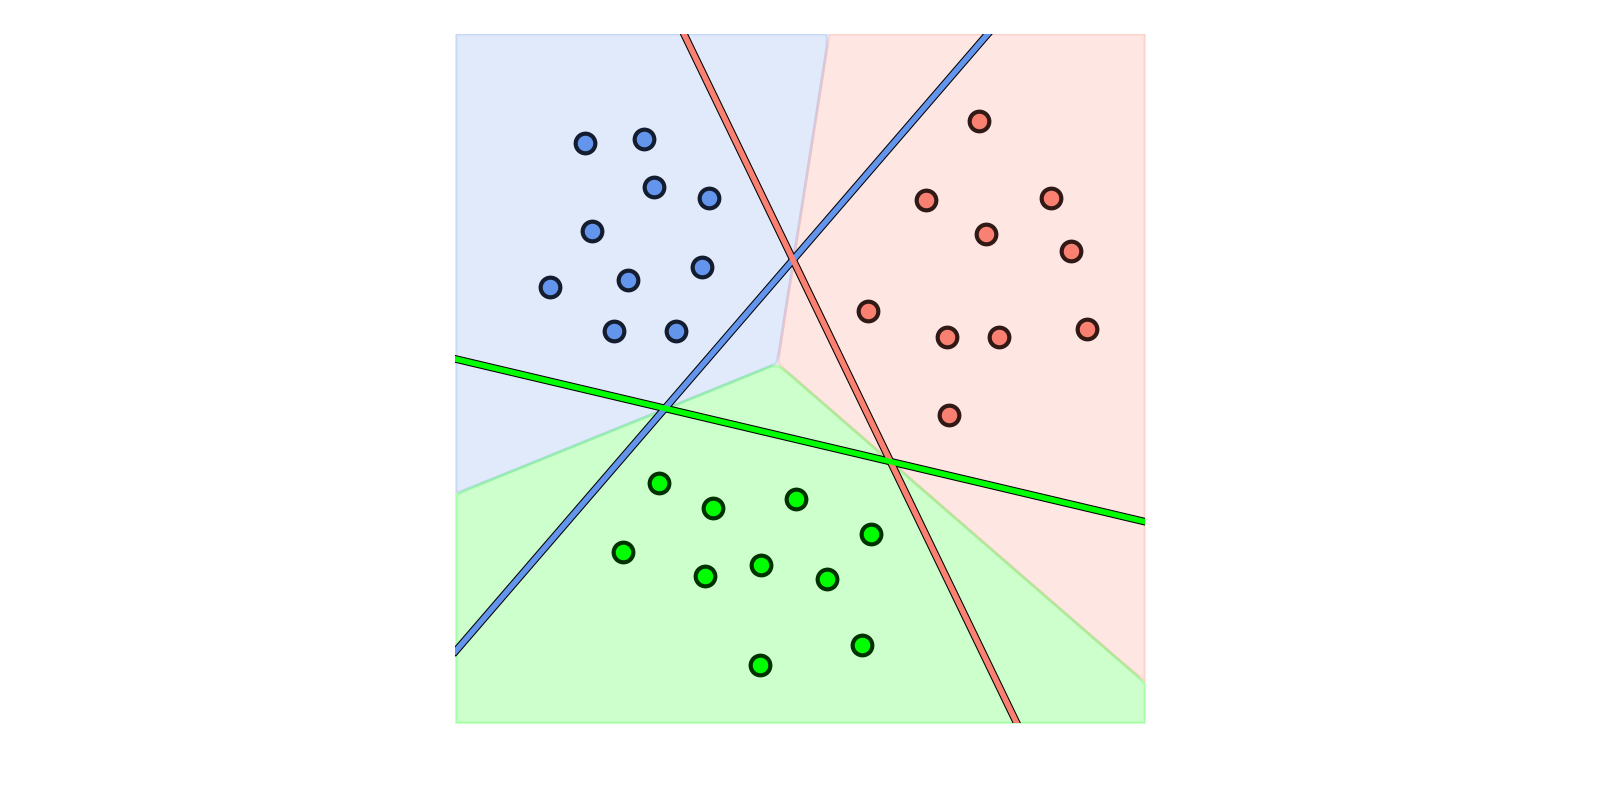

In [55]:
demo1.region_coloring(region = 'all')

In [ ]:
or - in other words writing this more compactly - that

\begin{equation}
y_p =\underset{c=1,...,C}{\mbox{argmax}}\,\,\,\mathbf{x}^{T}\mathbf{w}_{c}.
\end{equation}